# Imports

In [4]:
import pandas as pd
import numpy as np
import os
import inflection
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.utils.class_weight import compute_sample_weight


### 0.1. Helper functions

In [24]:
def classification_error(model_name, y_true, y_pred):
    # Calculando as métricas de classificação
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro') 
    f1 = f1_score(y_true, y_pred, average='macro') 

    # Retornando os resultados em um DataFrame
    return pd.DataFrame({
        'Model Name': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1]
    })

# Loading Data

In [29]:
df = pd.read_csv(r'C:\Users\PâmelaBotelhoMagalhã\OneDrive - Dataside\Documentos\Estudos\fraud\creditcard.csv\creditcard.csv')

# 1.0 Data Description

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

1.1. Data Dimensions

In [6]:
df.shape

(284807, 31)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

1.4 Check N/A's

In [8]:
df.isnull().sum().sort_values(ascending=False).head(31)

Time      0
V16       0
Amount    0
V28       0
V27       0
V26       0
V25       0
V24       0
V23       0
V22       0
V21       0
V20       0
V19       0
V18       0
V17       0
V15       0
V1        0
V14       0
V13       0
V12       0
V11       0
V10       0
V9        0
V8        0
V7        0
V6        0
V5        0
V4        0
V3        0
V2        0
Class     0
dtype: int64

1.5 Numerical Attributes

In [9]:
#Central Tendency - Mean and Median
ct1 = pd.DataFrame (df.apply(np.mean)).T
ct2 = pd.DataFrame (df.apply(np.median)).T

# Dispersion - std, min, max, range, skew and kurtosis
d1 = pd.DataFrame (df.apply(np.std)).T
d2 = pd.DataFrame (df.apply(min)).T
d3 = pd.DataFrame (df.apply(max)).T
d4 = pd.DataFrame (df.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (df.apply (lambda x: x.skew () )).T
d6 = pd.DataFrame (df.apply (lambda x: x.kurtosis () )).T

#Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Time,0.000000,172792.000000,172792.000000,9.481386e+04,84692.000000,47488.062585,-0.035568,-1.293530
1,V1,-56.407510,2.454930,58.862440,1.168375e-15,0.018109,1.958692,-3.280667,32.486679
2,V2,-72.715728,22.057729,94.773457,3.416908e-16,0.065486,1.651306,-4.624866,95.773106
3,V3,-48.325589,9.382558,57.708148,-1.379537e-15,0.179846,1.516252,-2.240155,26.619551
4,V4,-5.683171,16.875344,22.558515,2.074095e-15,-0.019847,1.415866,0.676292,2.635455
5,V5,-113.743307,34.801666,148.544973,9.604066e-16,-0.054336,1.380244,-2.425901,206.904560
6,V6,-26.160506,73.301626,99.462131,1.487313e-15,-0.274187,1.332269,1.826581,42.642494
7,V7,-43.557242,120.589494,164.146736,-5.556467e-16,0.040103,1.237091,2.553907,405.607417
8,V8,-73.216718,20.007208,93.223927,1.213481e-16,0.022358,1.194351,-8.521944,220.586974
9,V9,-13.434066,15.594995,29.029061,-2.406331e-15,-0.051429,1.098630,0.554680,3.731311


# 2.0. Feature Selection

In [30]:
df1 = df.copy()

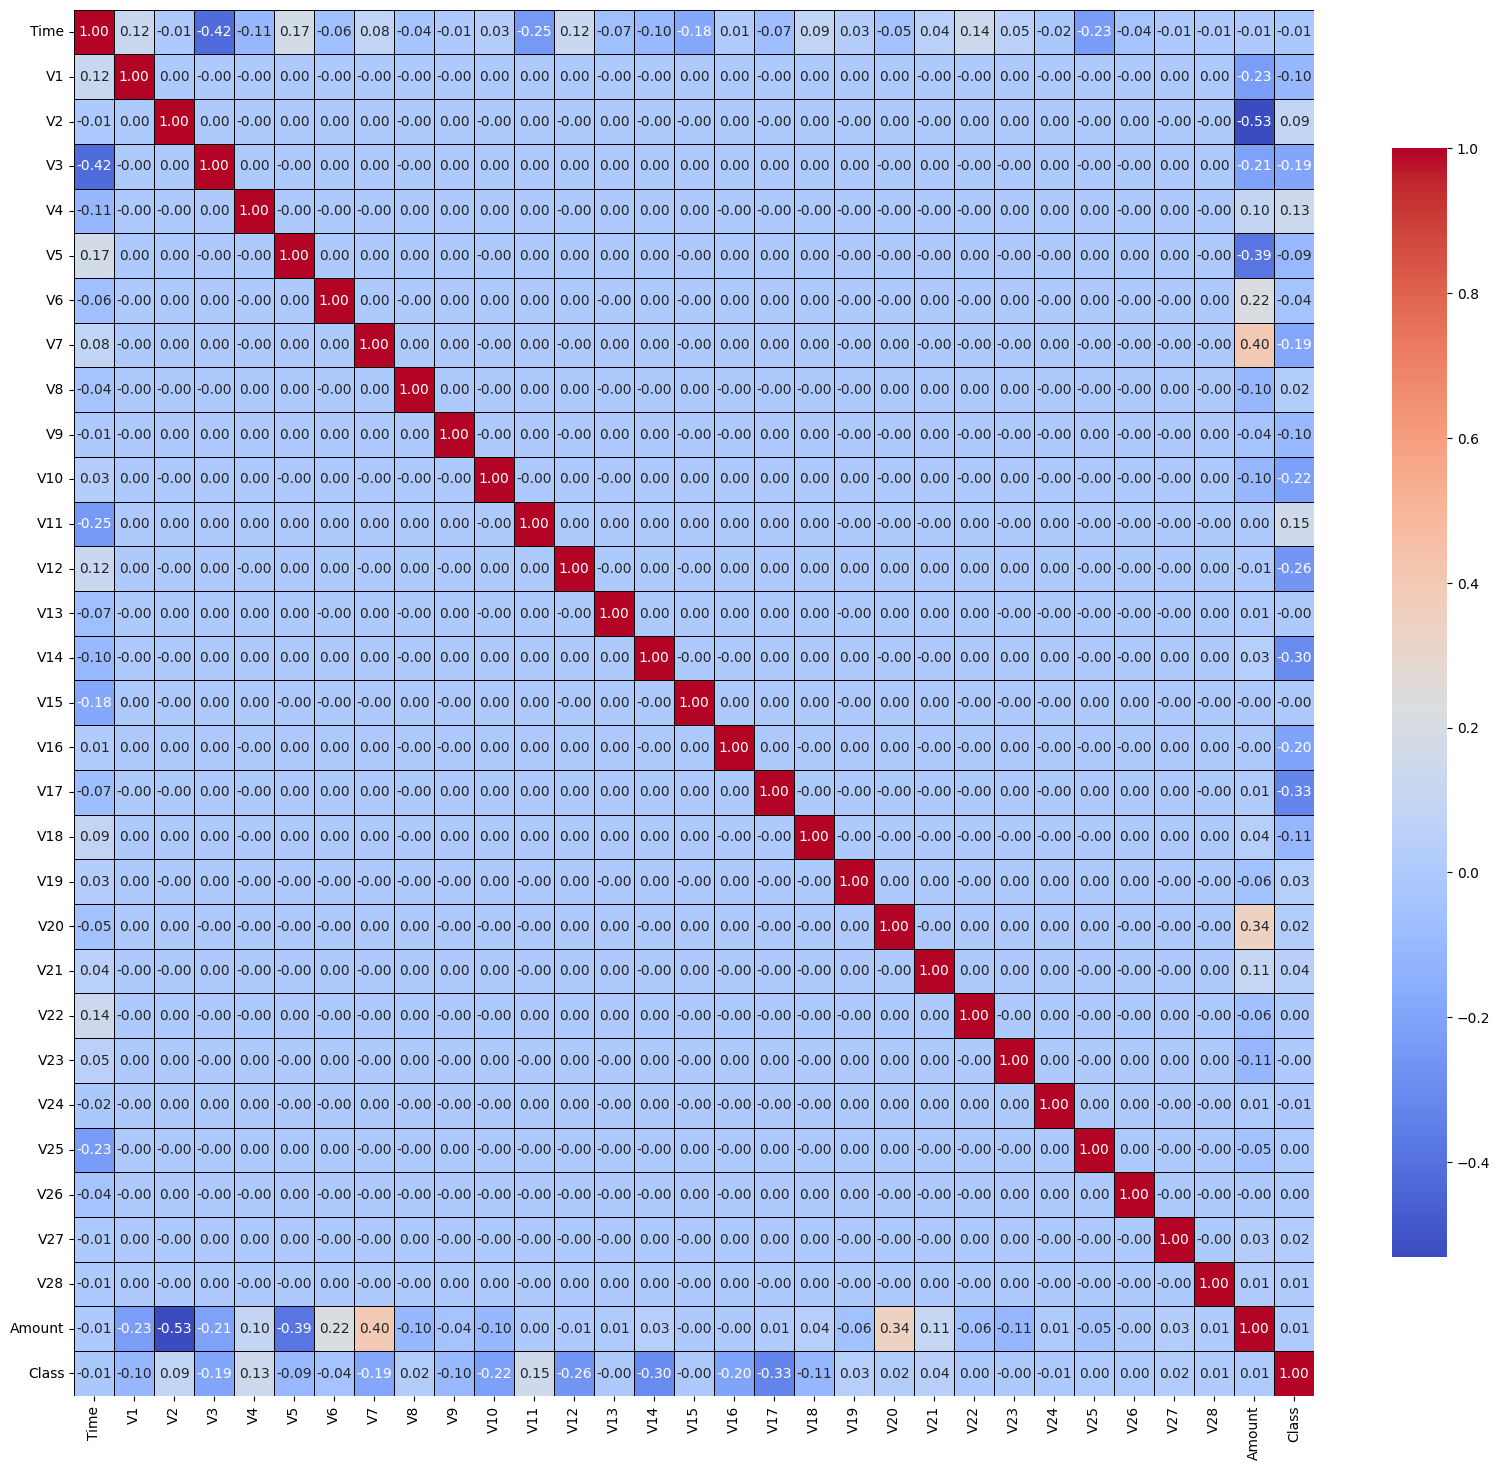

In [12]:
plt.figure(figsize=(20, 18))
#Matriz de Correlação
correlation = df1.corr(method='pearson')

# Heatmap com rotação nos rótulos
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, linecolor='black', xticklabels=correlation.columns, yticklabels=correlation.columns, cbar_kws={"shrink": 0.8})

# Espaçamento entre os rótulos
plt.yticks(rotation=0)
plt.xticks(rotation=90)

plt.show()

# 3.0. EDA - ANALISE EXPLORATORIA DOS DADOS

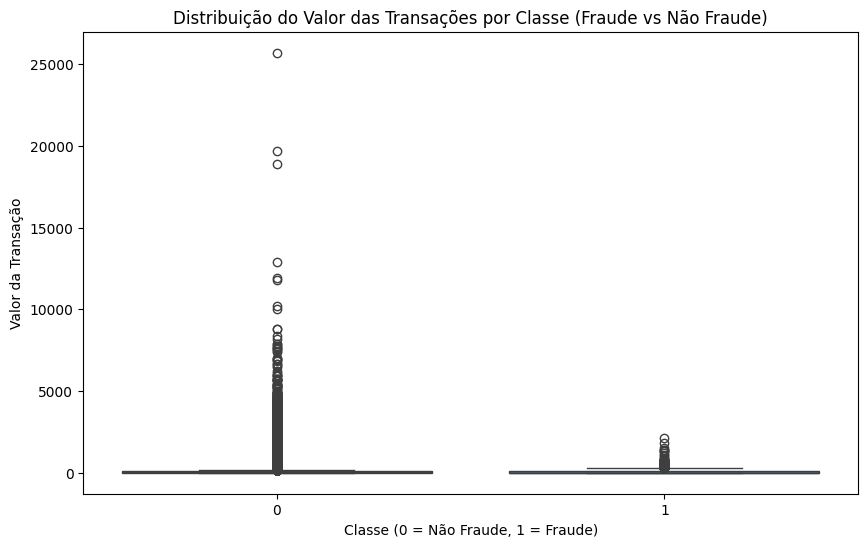

In [71]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df1)
plt.title('Distribuição do Valor das Transações por Classe (Fraude vs Não Fraude)')
plt.xlabel('Classe (0 = Não Fraude, 1 = Fraude)')
plt.ylabel('Valor da Transação')
plt.show()

# 4.0. DATA PREPARATION

### 4.1 Split

In [31]:
X = df1.drop('Class', axis=1) 
y = df1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
#Validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

# 5.0. FEATURE SELECTION

## 5.1. RFE as a feature selector

In [32]:
X_train_n = X_train
y_train_n = y_train.values.ravel()

# Instanciando o RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1)

# Configurando o RFE
rfe = RFE(estimator=rf, n_features_to_select=20)

# Ajustando o RFE ao conjunto de treinamento
rfe.fit(X_train_n, y_train_n)

# Verificando as features selecionadas
selected_features = X_train_n.columns[rfe.support_]

print("Selected features: ", selected_features)

Selected features:  Index(['V1', 'V2', 'V3', 'V4', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V13',
       'V14', 'V16', 'V17', 'V18', 'V20', 'V21', 'V26', 'V27', 'Amount'],
      dtype='object')


# 6.0. MACHINE LEARNING MODELLING

In [33]:
X_selected = df1[selected_features]
X = X_selected
y = df1['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
#Validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=0)

## 6.1 DecisionTreeClassifier

In [54]:
# Treinamento do modelo DecisionTreeClassifier
model_dt = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train,
                                                                    # Balance datacet
    #sample_weight = compute_sample_weight(
        #class_weight = 'balanced',
        #y = y_train
    #)
)

# Previsão
yhat_dt = model_dt.predict(X_test)
yprobs = model_dt.predict_proba(X_test)[:,1]

# Avaliação de desempenho do modelo DecisionTreeClassifier
dt_result = classification_error('DecisionTreeClassifier', y_test, yhat_dt)
print(dt_result)
print(classification_report(y_test, yhat_dt))

# Avaliando a curva ROC e a AUC
precision, recall, thresholds = precision_recall_curve(y_test, yprobs)
print(f'AUCRP: {100*auc(recall, precision):.0f}%')

               Model Name  Accuracy  Precision    Recall  F1 Score
0  DecisionTreeClassifier  0.999457   0.955348  0.879566  0.914006
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.91      0.76      0.83       162

    accuracy                           1.00     93987
   macro avg       0.96      0.88      0.91     93987
weighted avg       1.00      1.00      1.00     93987

AUCRP: 71%


Text(0, 0.5, 'Recall')

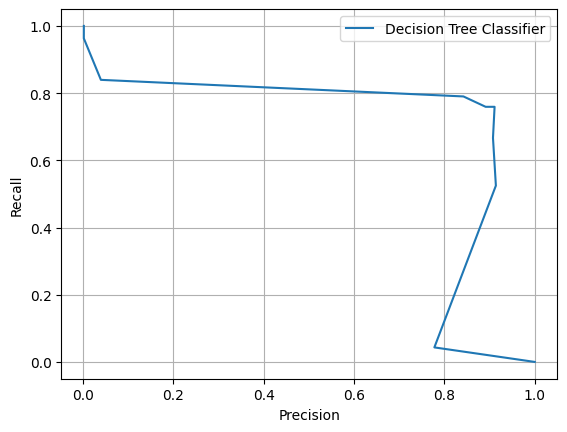

In [52]:
#precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test,yprobs)

fig, ax = plt.subplots()
ax.grid()
ax.plot(precision, recall, label = 'Decision Tree Classifier')
ax.legend()
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')

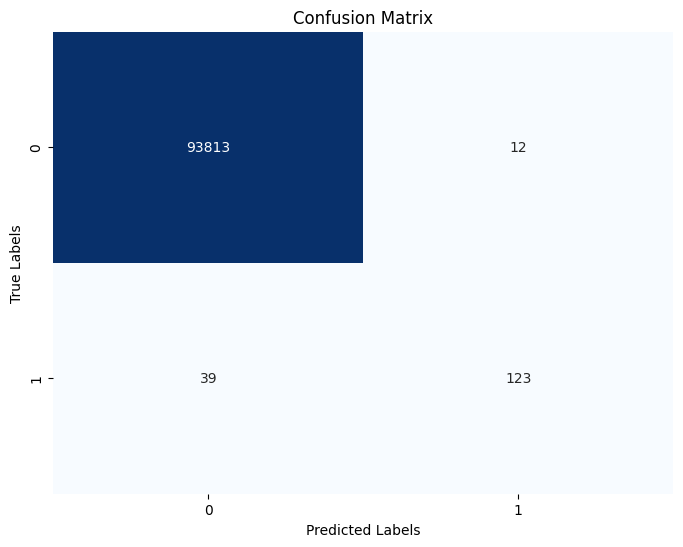

In [53]:
# Calculando a matriz de confusão
cm = confusion_matrix(y_test, yhat_dt)

# Plot com heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 6.2 XGBoostClassifier

In [56]:
# Treinamento modelo XGBoostClassifier
model_xg = XGBClassifier(colsample_bytree = 0.8,
    learning_rate= 0.1,
    max_depth = 3, 
    n_estimators = 200, 
    subsample = 0.8,random_state = 42, eval_metric='logloss',  
    early_stopping_rounds=10).fit(
    X_train, y_train,
    eval_set = [(X_val,y_val)],

)

# Previsão
yhat_xg = model_xg.predict(X_test)
yprobs = model_xg.predict_proba(X_test)[:,1]

# Avaliação de desempenho do modelo XGBClassifier
xg_result = classification_error('XGBClassifier', y_test, yhat_xg)
print(xg_result)
print(classification_report(y_test, yhat_xg))

# Avaliando a curva ROC e a AUC
precision, recall, thresholds = precision_recall_curve(y_test, yprobs)
print(f'AUCRP: {100*auc(recall, precision):.0f}%')

[0]	validation_0-logloss:0.11792
[1]	validation_0-logloss:0.10602
[2]	validation_0-logloss:0.09546
[3]	validation_0-logloss:0.08605
[4]	validation_0-logloss:0.07768
[5]	validation_0-logloss:0.07017
[6]	validation_0-logloss:0.06343
[7]	validation_0-logloss:0.05739
[8]	validation_0-logloss:0.05199
[9]	validation_0-logloss:0.04712
[10]	validation_0-logloss:0.04276
[11]	validation_0-logloss:0.03882
[12]	validation_0-logloss:0.03529
[13]	validation_0-logloss:0.03210
[14]	validation_0-logloss:0.02922
[15]	validation_0-logloss:0.02662
[16]	validation_0-logloss:0.02429
[17]	validation_0-logloss:0.02219
[18]	validation_0-logloss:0.02029
[19]	validation_0-logloss:0.01858
[20]	validation_0-logloss:0.01704
[21]	validation_0-logloss:0.01565
[22]	validation_0-logloss:0.01438
[23]	validation_0-logloss:0.01325
[24]	validation_0-logloss:0.01221
[25]	validation_0-logloss:0.01127
[26]	validation_0-logloss:0.01044
[27]	validation_0-logloss:0.00969
[28]	validation_0-logloss:0.00900
[29]	validation_0-loglos

Text(0, 0.5, 'Recall')

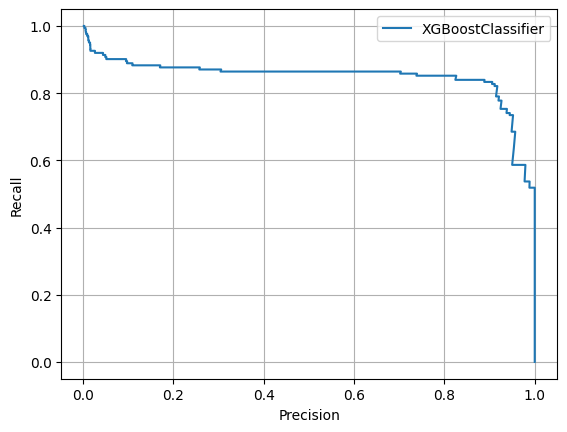

In [57]:
precision, recall, thresholds = precision_recall_curve(y_test,yprobs)

fig, ax = plt.subplots()
ax.grid()
ax.plot(precision, recall, label = 'XGBoostClassifier')
ax.legend()
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')

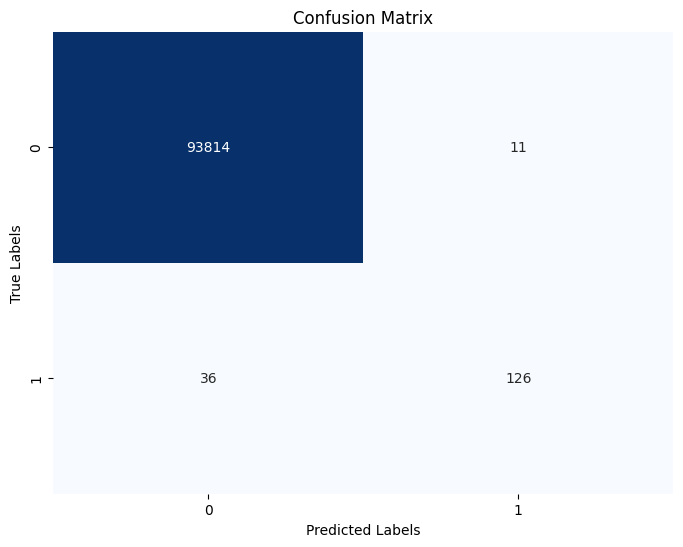

In [58]:
# Calculando a matriz de confusão
cm = confusion_matrix(y_test, yhat_xg)

# Plotando a matriz de confusão 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 6.2 Logistic Regressor

In [45]:
# Treinamento LogisticRegression
model_lr = LogisticRegression(random_state=42, max_iter=1000)
model_lr.fit(X_train, y_train)

# Previsão
yhat_lr = model_lr.predict(X_test)
yprobs = model_lr.predict_proba(X_test)[:,1]

# Avaliação de desempenho do modelo LogisticRegression
lr_result = classification_error('Logistic Regression', y_test, yhat_lr)
print(lr_result)
print(classification_report(y_test, yhat_lr))

# Avaliando a curva ROC e a AUC
precision, recall, thresholds = precision_recall_curve(y_test, yprobs)
print(f'AUCRP: {100*auc(recall, precision):.0f}%')

            Model Name  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.999096    0.93651  0.777708  0.839396
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.87      0.56      0.68       162

    accuracy                           1.00     93987
   macro avg       0.94      0.78      0.84     93987
weighted avg       1.00      1.00      1.00     93987

AUCRP: 75%


Text(0, 0.5, 'Recall')

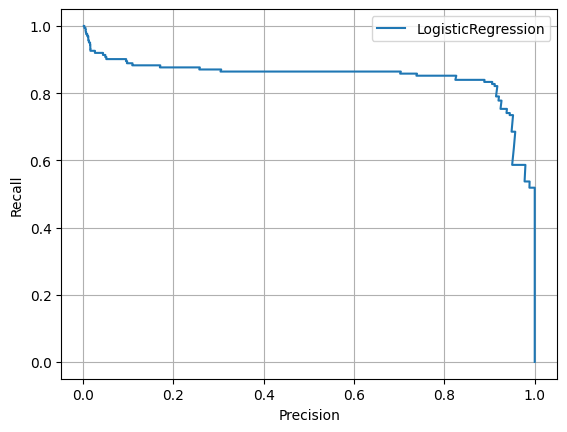

In [59]:
precision, recall, thresholds = precision_recall_curve(y_test,yprobs)

fig, ax = plt.subplots()
ax.grid()
ax.plot(precision, recall, label = 'LogisticRegression')
ax.legend()
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')

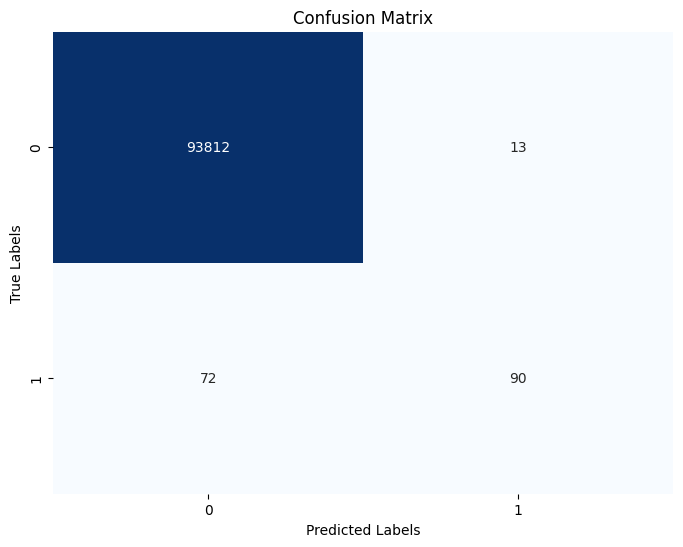

In [61]:
# Calculando a matriz de confusão
cm = confusion_matrix(y_test, yhat_lr)

# Plotando a matriz de confusão 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 7.0. HYPERPARAMETER FINE TUNING

## 7.1. Grid Search

In [28]:
# Definição do modelo
model = XGBClassifier(random_state=42, 
    eval_metric='logloss',  
    use_label_encoder=False,
    early_stopping_rounds=10,
)

# Definição da grade de hiperparâmetros
param_grid = {
    'n_estimators': [2000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Configuração do GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)

# Treinando o modelo usando GridSearchCV
grid_search.fit(X_train, y_train, eval_set = [(X_val,y_val)])

# Melhor modelo
best_model = grid_search.best_estimator_

# Previsão
yhat_dt = best_model.predict(X_test)
yprobs = best_model.predict_proba(X_test)[:,1]

# Avaliação de desempenho do melhor modelo
dt_result = classification_error('XGBoostClassifier (Best)', y_test, yhat_dt)
print(dt_result)
print(classification_report(y_test, yhat_dt))

# Avaliando a curva ROC e a AUC
precision, recall, thresholds = precision_recall_curve(y_test, yprobs)
print(f'AUCRP: {100*auc(recall, precision):.0f}%')

# Exibindo os melhores hiperparâmetros
print("Melhores hiperparâmetros encontrados:", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[0]	validation_0-logloss:0.13019
[1]	validation_0-logloss:0.12877
[2]	validation_0-logloss:0.12738
[3]	validation_0-logloss:0.12600
[4]	validation_0-logloss:0.12465
[5]	validation_0-logloss:0.12331
[6]	validation_0-logloss:0.12199
[7]	validation_0-logloss:0.12069
[8]	validation_0-logloss:0.11940
[9]	validation_0-logloss:0.11813
[10]	validation_0-logloss:0.11688
[11]	validation_0-logloss:0.11564
[12]	validation_0-logloss:0.11442
[13]	validation_0-logloss:0.11321
[14]	validation_0-logloss:0.11201
[15]	validation_0-logloss:0.11083
[16]	validation_0-logloss:0.10967
[17]	validation_0-logloss:0.10852
[18]	validation_0-logloss:0.10738
[19]	validation_0-logloss:0.10626
[20]	validation_0-logloss:0.10515
[21]	validation_0-logloss:0.10405
[22]	validation_0-logloss:0.10297
[23]	validation_0-logloss:0.10189
[24]	validation_0-logloss:0.10083
[25]	validation_0-logloss:0.09979
[26]	validation_0-logloss:0.09875
[27]	validation_0-logloss:0.09

 ## 7.2. Final Model

In [26]:
param_tuned = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 5, 
    'n_estimators': 200, 
    'subsample': 0.8,
        }

In [27]:
# Treinamento do modelo
model_xgb_tuned = XGBClassifier(
    n_estimators=param_tuned['n_estimators'],
    learning_rate=param_tuned['learning_rate'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytree=param_tuned['colsample_bytree'],
    eval_metric='logloss',  
    use_label_encoder=False,
    early_stopping_rounds=10,
    random_state=42
)

# Treinamento com conjunto de validação para early stopping
model_xgb_tuned.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Previsão
yhat_dt = model_xgb_tuned.predict(X_test)
yprobs = model_xgb_tuned.predict_proba(X_test)[:,1]

# Avaliação de desempenho
dt_result = classification_error('XGBoostClassifier', y_test, yhat_dt)
print(dt_result)
print(classification_report(y_test, yhat_dt))

# Avaliando a curva ROC e a AUC
precision, recall, thresholds = precision_recall_curve(y_test, yprobs)
print(f'AUCRP: {100 * auc(recall, precision):.0f}%')

          Model Name  Accuracy  Precision    Recall  F1 Score
0  XGBoostClassifier  0.999521   0.963317  0.891922  0.924629
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     93825
           1       0.93      0.78      0.85       162

    accuracy                           1.00     93987
   macro avg       0.96      0.89      0.92     93987
weighted avg       1.00      1.00      1.00     93987

AUCRP: 85%
